In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

%run cleaning_ucdp.ipynb

In [182]:
country = "sri_lanka"
ucleaner = UCDPCleaner(country)

ucleaner.load_data(use_high=True, full_path=None)
data_duration = ucleaner.duration()
ucleaner.set_data(data_duration)

date = "06-01-2011"
cut = ucleaner.cut_off_end(date)
ucleaner.set_data(cut)


Loading data from ../data/ucdp/sri_lanka.csv
Loading data from ../data/ucdp/sri_lanka.csv


dates range from 1989-01-01 to 2011-01-22


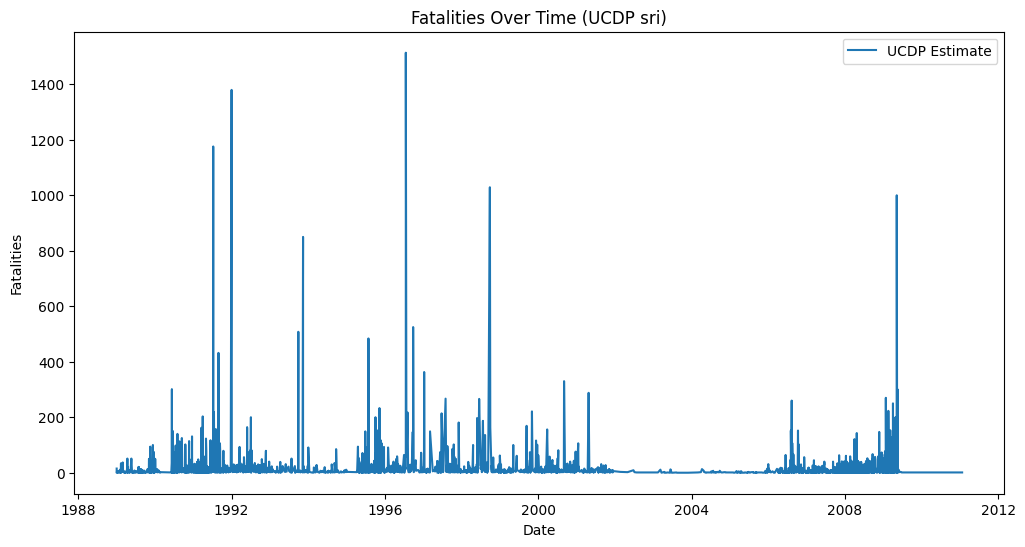

In [183]:
# plot of resampled data
ucleaner.plot()

In [184]:
# information from wikipedia: https://www.wikiwand.com/en/Category:Phases_of_the_Sri_Lankan_Civil_War

data = ucleaner.data
data = data.copy()
# not covered by data: ('23 July 1983', '29 July 1987')
tuples = [('23 July 1983', '29 July 1987'), ('June 10, 1990', 'January 1995'), ('19 April 1995','22 February 2002'), ('26 July 2006','18 May 2009')]

# Convert tuples to datetime ranges
date_ranges = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in tuples]

# Define a function to check if a date is within any wartime period and calculate days since war start
def in_wartime_and_days_since_start(date):
    days_since_start = np.nan
    for start, end in date_ranges:
        if start <= date:
            days_since_start = (date - start).days
        if start <= date <= end:
            return 1, days_since_start
    return 0, days_since_start

# Apply the function to the 'date_start' column in the data
data['wartime'], data['since_war_start'] = zip(*data['date_start'].apply(in_wartime_and_days_since_start))
print(data['wartime'].value_counts(normalize=True))


1    0.894645
0    0.105355
Name: wartime, dtype: float64


In [185]:
ucleaner.set_data(data)

dates range from 1989-01-31 to 2011-01-31


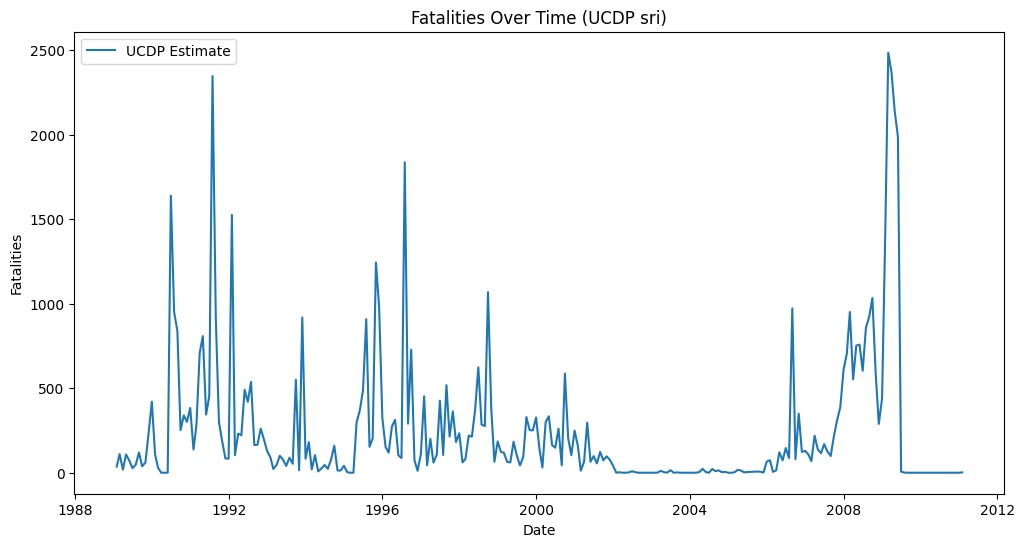

In [186]:
ucleaner.resample('M', war_var=True)
ucleaner.plot(use_resampled=True) 

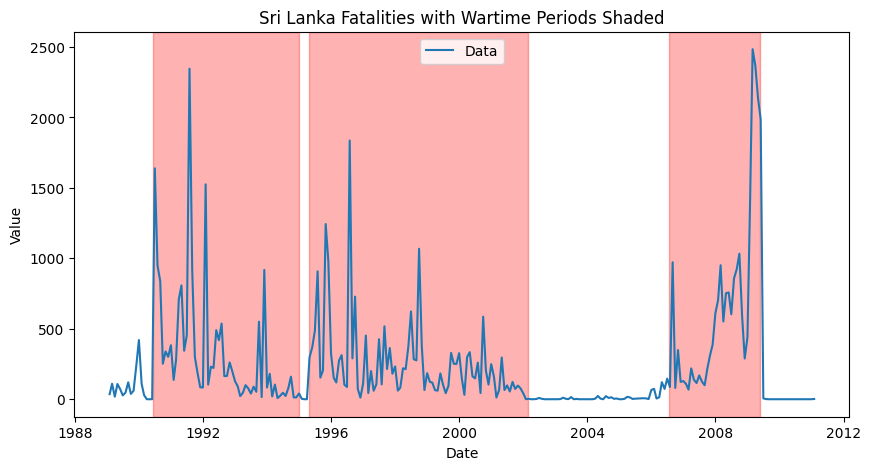

In [187]:
data = ucleaner.resampled
# Plotting the data with wartime periods shaded
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['best'], label='Data')  # Replace 'some_data_column' with the actual data column to plot
for start, end in date_ranges:
    if data[(data.index >= start) & (data.index <= end)].shape[0] > 0:
        plt.axvspan(start, end, color='red', alpha=0.3)
plt.legend()
plt.title('Sri Lanka Fatalities with Wartime Periods Shaded')
plt.xlabel('Date')
plt.ylabel('Value')  # Replace 'Value' with the actual description of the data column
plt.show()


In [188]:
data = ucleaner.resampled.copy()
data['avg_duration'] = data['avg_duration'].fillna(pd.Timedelta(seconds=0))
data['avg_duration'] = data['avg_duration'].dt.total_seconds().astype(int)
data.head()

,best,unique_conflicts,avg_duration,events_count,wartime,since_war_start
date_start,,,,,,
1989-01-31,36,4,6998400,9,0,2000.000000
1989-02-28,110,4,14400,12,0,2031.583333
1989-03-31,18,4,61714,7,0,2060.571429
1989-04-30,108,4,6171,14,0,2094.214286
1989-05-31,72,5,271542,7,0,2122.857143


In [203]:
def create_sliding_window(data, window_size):
    for i in range(1, window_size + 1):
        data[f'best_lag_{i}'] = data['best'].shift(i)
    return data.dropna()

window_size = 4  # 4-6 seems to be ideal
X_best = create_sliding_window(data, window_size)
X_best.head()

,best,unique_conflicts,avg_duration,events_count,wartime,since_war_start,best_lag_1,best_lag_2,best_lag_3,best_lag_4
date_start,,,,,,,,,,
1989-05-31,72,5,271542,7,0,2122.857143,108.0,18.0,110.0,36.0
1989-06-30,27,2,0,12,0,2152.416667,72.0,108.0,18.0,110.0
1989-07-31,47,3,7854,11,0,2187.090909,27.0,72.0,108.0,18.0
1989-08-31,120,4,100800,36,0,2214.722222,47.0,27.0,72.0,108.0
1989-09-30,38,3,31831,19,0,2246.210526,120.0,47.0,27.0,72.0


In [204]:
y = X_best['best']
y.head()

date_start
1989-05-31     72
1989-06-30     27
1989-07-31     47
1989-08-31    120
1989-09-30     38
Name: best, dtype: int64

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = X_best.drop(columns=["best", "avg_duration", "unique_conflicts", "events_count"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# with events level data: 94864.87749555559
# without: 187003.2041377778

Mean Squared Error: 187003.2041377778


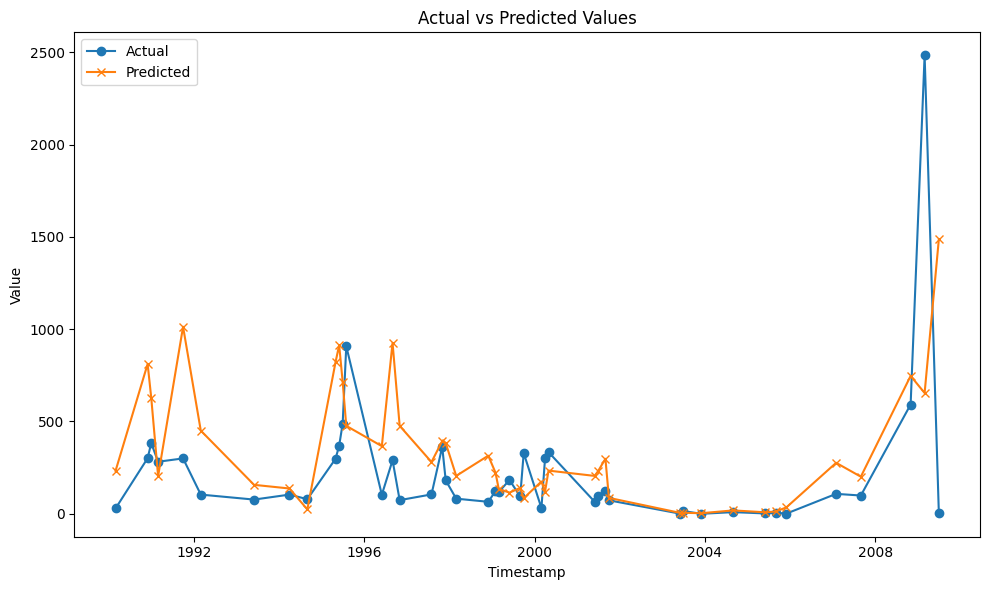

In [206]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
indices = range(len(y_test))

# Sort y_test by index to align with the timestamps
sorted_indices = y_test.sort_index().index
sorted_y_test = y_test.sort_index()
sorted_predictions = [predictions[i] for i in np.argsort(y_test.index)]

plt.plot(sorted_indices, sorted_y_test, label='Actual', marker='o')
plt.plot(sorted_indices, sorted_predictions, label='Predicted', marker='x')

plt.title('Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()


plt.tight_layout()
plt.show()

In [285]:
data_with_lags.shape

(222, 7)

In [276]:
data_with_lags = X_best.drop(columns=["avg_duration", "unique_conflicts", "events_count"])

# Splitting the data based on the date
train_data = data_with_lags[data_with_lags.index < pd.to_datetime('1998-01-01')]
test_data = data_with_lags[(data_with_lags.index >= pd.to_datetime('1998-01-01')) & (data_with_lags.index < pd.to_datetime('1999-01-01'))]

# Prepare features and target
X_train = train_data.drop(columns=['best'])
y_train = train_data['best']
X_test = test_data.drop(columns=['best'])
y_test = test_data['best']


In [277]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

X_test[['best_lag_1', 'best_lag_2', 'best_lag_3', 'best_lag_4']] = np.nan

predictions = []

index_future_dates = pd.date_range(start=train_data.index[-1] + pd.DateOffset(months=1), periods=len(X_test), freq='M')
print(index_future_dates)
index_future_dates = y_test.index
index_future_dates


DatetimeIndex(['1998-01-31', '1998-02-28', '1998-03-31', '1998-04-30',
               '1998-05-31', '1998-06-30', '1998-07-31', '1998-08-31',
               '1998-09-30', '1998-10-31', '1998-11-30', '1998-12-31'],
              dtype='datetime64[ns]', freq='M')


DatetimeIndex(['1998-01-31', '1998-02-28', '1998-03-31', '1998-04-30',
               '1998-05-31', '1998-06-30', '1998-07-31', '1998-08-31',
               '1998-09-30', '1998-10-31', '1998-11-30', '1998-12-31'],
              dtype='datetime64[ns]', name='date_start', freq=None)

In [278]:
train_data.tail(4)

,best,wartime,since_war_start,best_lag_1,best_lag_2,best_lag_3,best_lag_4
date_start,,,,,,,
1997-09-30,214,1,877.142857,518.0,105.0,426.0,106.0
1997-10-31,363,1,912.714286,214.0,518.0,105.0,426.0
1997-11-30,181,1,939.315789,363.0,214.0,518.0,105.0
1997-12-31,233,1,973.000000,181.0,363.0,214.0,518.0


In [279]:
X_test.head()

,wartime,since_war_start,best_lag_1,best_lag_2,best_lag_3,best_lag_4
date_start,,,,,,
1998-01-31,1,1004.500000,NaN,NaN,NaN,NaN
1998-02-28,1,1033.875000,NaN,NaN,NaN,NaN
1998-03-31,1,1065.103448,NaN,NaN,NaN,NaN
1998-04-30,1,1089.160000,NaN,NaN,NaN,NaN
1998-05-31,1,1120.941176,NaN,NaN,NaN,NaN


In [280]:
lag_values = train_data.iloc[-1][['best', 'best_lag_1', 'best_lag_2', 'best_lag_3']].values

# Predict recursively and update lag values for the rest of X_test
for i in range(len(index_future_dates)):
    lag_cols = ['best_lag_1', 'best_lag_2', 'best_lag_3', 'best_lag_4']
    # Update the lag values for the current test instance
    X_test.loc[X_test.index[i], lag_cols] = lag_values
    # Predict the current value
    # print(model.predict(X_test.loc[X_test.index[0]:X_test.index[0]].values.reshape(1, -1)))
    current_prediction = model.predict(X_test.loc[X_test.index[i]].values.reshape(1, -1))

    predictions.append(current_prediction)
    # Update the lag_values to include the new prediction
    lag_values = np.roll(lag_values, 1)
    lag_values[0] = current_prediction
# print(lag_values)



/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_18554/2347852355.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag_values[0] = current_prediction
/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/var/folders/wb/67n5x4vj6qq_n5t85f5bvtww0000gn/T/ipykernel_18554/2347852355.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a singl

In [284]:
X_test.head()
# X_test.shape

(12, 6)

In [282]:

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 119417.34777500002


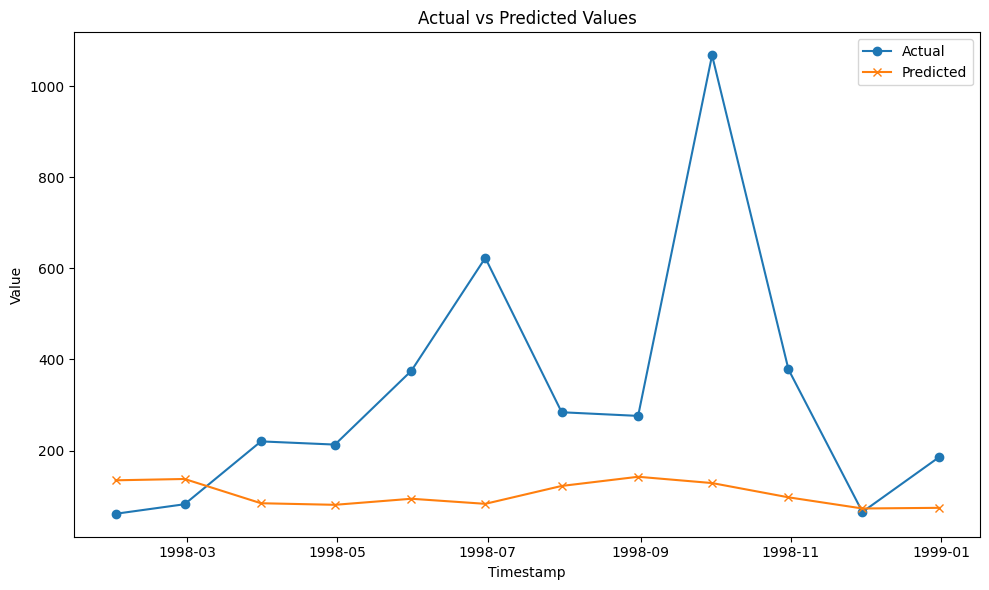

In [283]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
indices = range(len(y_test))

# Sort y_test by index to align with the timestamps
sorted_indices = y_test.sort_index().index
sorted_y_test = y_test.sort_index()
sorted_predictions = [predictions[i] for i in np.argsort(y_test.index)]

plt.plot(sorted_indices, sorted_y_test, label='Actual', marker='o')
plt.plot(sorted_indices, sorted_predictions, label='Predicted', marker='x')

plt.title('Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()


plt.tight_layout()
plt.show()